# Классификация изображений с помощью HOG+SVM

## Подготовка подготовка изображений

Подготовим изображения объектов для последующей их классификации:

In [1]:
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os

In [31]:
mode = 'val'  # 'val'/'train'
annotations_path = f'C:/Users/Vlad/Desktop/Isaid_dataset/{mode}/iSAID_{mode}.json'
img_path_input = f'C:/Users/Vlad/Desktop/Isaid_dataset/{mode}/images/'
img_output_path = f'C:/Users/Vlad/Downloads/ML_dataset/{mode}/'

i_max = 200 #максимальное число изображений каждой категории

with open(annotations_path, 'r', encoding='Utf-8') as json_data:
    annotations = json.load(json_data)

img_ann = {}
for img in annotations['images']:
    img_ann[img['id']] = []
for obj in annotations['annotations']:
    img_ann[obj['image_id']].append([obj['category_name'], (int(obj['bbox'][0]), int(obj['bbox'][1]), int(obj['bbox'][0] + obj['bbox'][2] - 1),
                 int(obj['bbox'][1] + obj['bbox'][3] - 1))])

for category in annotations['categories']:
    name = category['name']
    if not os.path.isdir(img_output_path + f'{name}'):
        os.makedirs(img_output_path + f'{name}')

i_cat = {}
for category in annotations['categories']:
    i_cat[category['name']] = 0

for img in tqdm(annotations['images']):
    im = Image.open(img_path_input + img['file_name'])
    im = im.convert('RGB')
    for obj in img_ann[img['id']]:
        if i_cat[obj[0]] >= i_max:
            continue
        try:
            im.crop(obj[1]).save(img_output_path + f'{obj[0]}/' + f'{i_cat[obj[0]]}.jpg')
            i_cat[obj[0]]+=1 
        except Exception:
            continue

100%|████████████████████████████████████████████████████████████████████████████████| 458/458 [01:37<00:00,  4.68it/s]


## Создание датасета

In [2]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import pprint
from skimage.feature import hog
pp = pprint.PrettyPrinter(indent=4)
import joblib
from skimage.io import imread
from skimage.transform import resize

Для начала требуется подготовить датасет (привести изображения к единому размеру и сделать подписи к рисункам):

In [22]:
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [6]:
data_path = f'C:/Users/Vlad/Downloads/ML_dataset/train'
os.listdir(data_path)

['baseball_diamond',
 'basketball_court',
 'Bridge',
 'Ground_Track_Field',
 'Harbor',
 'Helicopter',
 'Large_Vehicle',
 'plane',
 'Roundabout',
 'ship',
 'Small_Vehicle',
 'Soccer_ball_field',
 'storage_tank',
 'Swimming_pool',
 'tennis_court']

In [35]:
data_path = f'C:/Users/Vlad/Downloads/ML_dataset/train'

base_name = 'C:/Users/Vlad/Downloads/object_imgs_train'
width = 80
 
include = {'baseball_diamond',
 'basketball_court',
 'Bridge',
 'Ground_Track_Field',
 'Harbor',
 'Helicopter',
 'Large_Vehicle',
 'plane',
 'Roundabout',
 'ship',
 'Small_Vehicle',
 'Soccer_ball_field',
 'storage_tank',
 'Swimming_pool',
 'tennis_court'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

baseball_diamond
basketball_court
Bridge
Ground_Track_Field
Harbor
Helicopter
Large_Vehicle
plane
Roundabout
ship
Small_Vehicle
Soccer_ball_field
storage_tank
Swimming_pool
tennis_court


In [23]:
data_path = f'C:/Users/Vlad/Downloads/ML_dataset/val'

base_name = 'C:/Users/Vlad/Downloads/object_imgs_test'
width = 80
 
include = {'baseball_diamond',
 'basketball_court',
 'Bridge',
 'Ground_Track_Field',
 'Harbor',
 'Helicopter',
 'Large_Vehicle',
 'plane',
 'Roundabout',
 'ship',
 'Small_Vehicle',
 'Soccer_ball_field',
 'storage_tank',
 'Swimming_pool',
 'tennis_court'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

baseball_diamond
basketball_court
Bridge
Ground_Track_Field
Harbor
Helicopter
Large_Vehicle
plane
Roundabout
ship
Small_Vehicle
Soccer_ball_field
storage_tank
Swimming_pool
tennis_court


Загружаем датасет:

In [3]:
from collections import Counter

base_name = 'C:/Users/Vlad/Downloads/object_imgs_train'
width = 80

data_train = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data_train['data']))
print('keys: ', list(data_train.keys()))
print('description: ', data_train['description'])
print('image shape: ', data_train['data'][0].shape)
print('labels:', np.unique(data_train['label']))
 
Counter(data_train['label'])

number of samples:  8244
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) images in rgb
image shape:  (80, 80, 3)
labels: ['Bridge' 'Ground_Track_Field' 'Harbor' 'Helicopter' 'Large_Vehicle'
 'Roundabout' 'Small_Vehicle' 'Soccer_ball_field' 'Swimming_pool'
 'baseball_diamond' 'basketball_court' 'plane' 'ship' 'storage_tank'
 'tennis_court']


Counter({'baseball_diamond': 464,
         'basketball_court': 557,
         'Bridge': 600,
         'Ground_Track_Field': 352,
         'Harbor': 600,
         'Helicopter': 600,
         'Large_Vehicle': 600,
         'plane': 600,
         'Roundabout': 428,
         'ship': 600,
         'Small_Vehicle': 600,
         'Soccer_ball_field': 443,
         'storage_tank': 600,
         'Swimming_pool': 600,
         'tennis_court': 600})

In [5]:
base_name = 'C:/Users/Vlad/Downloads/object_imgs_test'
width = 80

data_test = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data_test['data']))
print('keys: ', list(data_test.keys()))
print('description: ', data_test['description'])
print('image shape: ', data_test['data'][0].shape)
print('labels:', np.unique(data_test['label']))
 
Counter(data_test['label'])

number of samples:  2774
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) images in rgb
image shape:  (80, 80, 3)
labels: ['Bridge' 'Ground_Track_Field' 'Harbor' 'Helicopter' 'Large_Vehicle'
 'Roundabout' 'Small_Vehicle' 'Soccer_ball_field' 'Swimming_pool'
 'baseball_diamond' 'basketball_court' 'plane' 'ship' 'storage_tank'
 'tennis_court']


Counter({'baseball_diamond': 200,
         'basketball_court': 154,
         'Bridge': 200,
         'Ground_Track_Field': 158,
         'Harbor': 200,
         'Helicopter': 86,
         'Large_Vehicle': 200,
         'plane': 200,
         'Roundabout': 188,
         'ship': 200,
         'Small_Vehicle': 200,
         'Soccer_ball_field': 188,
         'storage_tank': 200,
         'Swimming_pool': 200,
         'tennis_court': 200})

Выведем примеры полученных изображений:

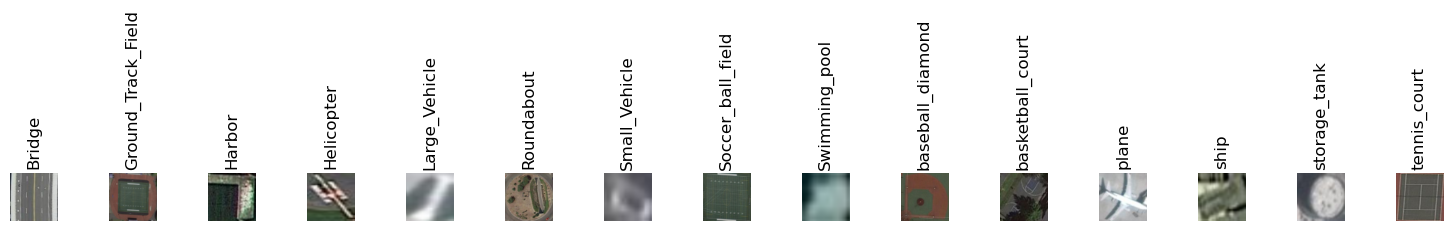

In [24]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data_train['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data_train['label'].index(label)
     
    ax.imshow(data_train['data'][idx])
    ax.axis('off')
    ax.set_title(label, rotation='vertical')

Создаем тренировочную и тестовую выборки:

In [6]:
X_train = np.array(data_train['data'])
y_train = np.array(data_train['label'])
X_test = np.array(data_test['data'])
y_test = np.array(data_test['label'])

Посмотрим распределение фотографий по категориям:

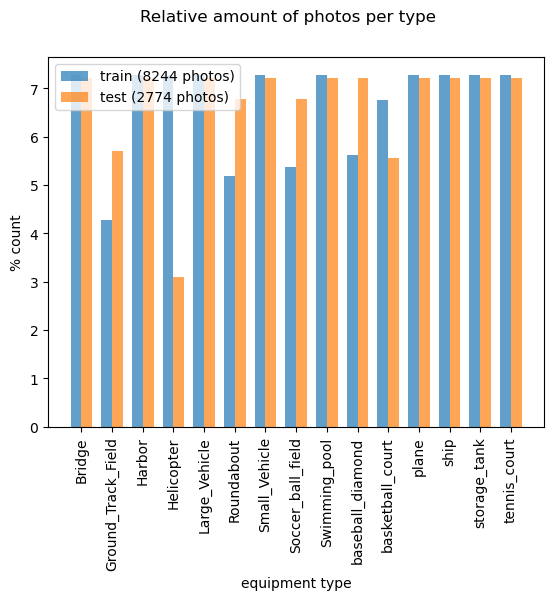

In [21]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation='vertical')
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 

plt.suptitle('Relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
])
plt.show()

## Обучение

Перед применением классификатора к изображениям необходимо сделать их черно-белыми, затем применить к ним HOG для выделения признаков и нормализовать полученные признаки. Классы для преобразований изображений:

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report
import skimage
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Пайплайн модели:

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(kernel='linear'))
])

In [60]:
from sklearn.metrics import accuracy_score
HOG_pipeline.fit(X_train, y_train)
y_pred = HOG_pipeline.predict(X_test)
accuracy_score(y_test,y_pred)

0.5353280461427542

Матрики модели:

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

            Bridge       0.53      0.68      0.60       200
Ground_Track_Field       0.41      0.51      0.45       158
            Harbor       0.49      0.54      0.51       200
        Helicopter       0.25      0.24      0.25        86
     Large_Vehicle       0.55      0.52      0.53       200
        Roundabout       0.46      0.51      0.48       188
     Small_Vehicle       0.41      0.40      0.40       200
 Soccer_ball_field       0.46      0.43      0.44       188
     Swimming_pool       0.52      0.46      0.49       200
  baseball_diamond       0.54      0.44      0.49       200
  basketball_court       0.57      0.58      0.58       154
             plane       0.75      0.77      0.76       200
              ship       0.34      0.21      0.26       200
      storage_tank       0.62      0.70      0.66       200
      tennis_court       0.86      0.89      0.87       200

          accuracy                    

Матрица запутанности:

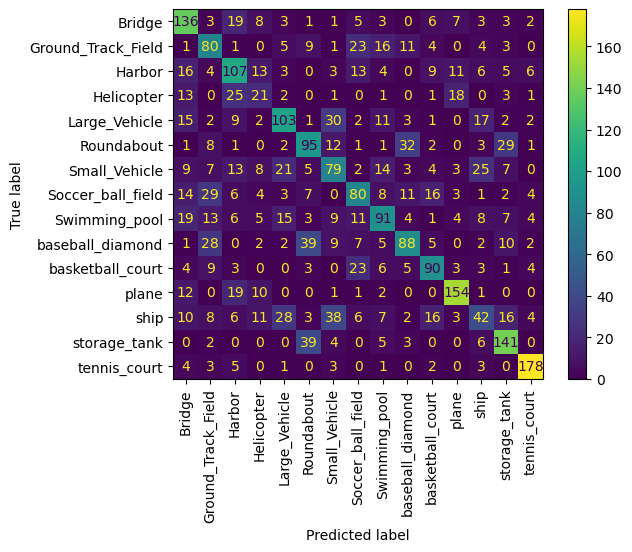

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=HOG_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=HOG_pipeline.classes_)
disp.plot(xticks_rotation='vertical')
plt.show()

## Эксперименты

Попробуем повысить качество модели. Для этого подберём оптимальные параметры для HOG:

In [69]:
import optuna
def objective_hog(trial):
    orientations = trial.suggest_categorical("orientations", [8, 9])
    cells_per_block = trial.suggest_categorical("cells_per_block", [(2, 2), (3, 3)])
    pixels_per_cell = trial.suggest_categorical("pixels_per_cell", [(8, 8), (10, 10), (12, 12)])
    HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=pixels_per_cell, 
        cells_per_block=cells_per_block, 
        orientations=orientations, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(kernel='linear'))
    ])
    HOG_pipeline.fit(X_train, y_train)
    y_pred = HOG_pipeline.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_hog, n_trials=12)
study.best_params

[I 2024-02-27 18:05:30,593] A new study created in memory with name: no-name-98cfb1a9-6ad4-45e3-9ff7-4650bbeebde1
C:\Users\Vlad\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2) which is of type tuple.
  warnings.warn(message)
C:\Users\Vlad\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
C:\Users\Vlad\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (8, 8) which is of type tuple.
  warnings.warn(message)
C:\Users\Vlad\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: C

[I 2024-02-27 18:16:52,187] Trial 5 finished with value: 0.5450612833453496 and parameters: {'orientations': 8, 'cells_per_block': (2, 2), 'pixels_per_cell': (12, 12)}. Best is trial 0 with value: 0.5825522710886806.
C:\Users\Vlad\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 2) which is of type tuple.
  warnings.warn(message)
C:\Users\Vlad\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
C:\Users\Vlad\anaconda3\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (8, 8) which is of type tuple.
  warni

[I 2024-02-27 19:21:09,630] Trial 11 finished with value: 0.6005767844268205 and parameters: {'orientations': 9, 'cells_per_block': (3, 3), 'pixels_per_cell': (8, 8)}. Best is trial 10 with value: 0.6005767844268205.


{'orientations': 9, 'cells_per_block': (3, 3), 'pixels_per_cell': (8, 8)}

SVC с линейным ядром:

In [10]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8), 
        cells_per_block=(3, 3), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(kernel='linear'))
])

HOG_pipeline.fit(X_train, y_train)
y_pred = HOG_pipeline.predict(X_test)
accuracy_score(y_test,y_pred)

0.6005767844268205

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

            Bridge       0.57      0.79      0.66       200
Ground_Track_Field       0.57      0.57      0.57       158
            Harbor       0.57      0.64      0.60       200
        Helicopter       0.35      0.23      0.28        86
     Large_Vehicle       0.54      0.56      0.55       200
        Roundabout       0.56      0.59      0.57       188
     Small_Vehicle       0.42      0.36      0.39       200
 Soccer_ball_field       0.54      0.47      0.50       188
     Swimming_pool       0.59      0.53      0.56       200
  baseball_diamond       0.65      0.56      0.61       200
  basketball_court       0.65      0.71      0.68       154
             plane       0.80      0.86      0.83       200
              ship       0.32      0.23      0.26       200
      storage_tank       0.63      0.76      0.69       200
      tennis_court       0.93      0.95      0.94       200

          accuracy                    

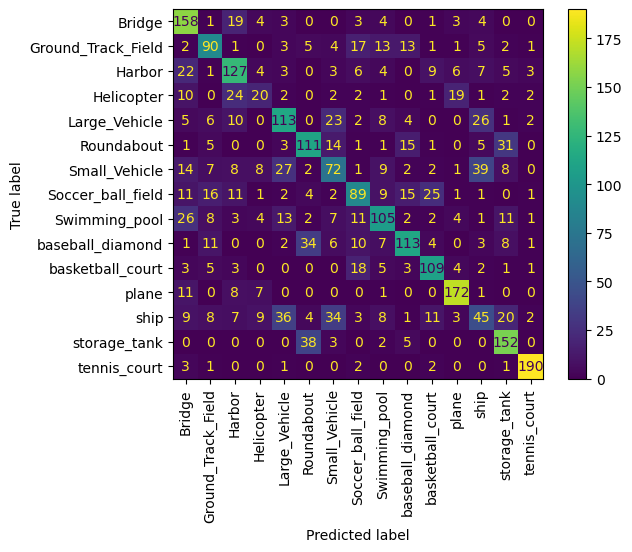

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=HOG_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=HOG_pipeline.classes_)
disp.plot(xticks_rotation='vertical')
plt.show()

SVC с ядром rbf:

In [13]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8), 
        cells_per_block=(3, 3), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(kernel='rbf'))
])

HOG_pipeline.fit(X_train, y_train)
y_pred = HOG_pipeline.predict(X_test)
accuracy_score(y_test,y_pred)

0.6914203316510454

In [14]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

            Bridge       0.69      0.81      0.75       200
Ground_Track_Field       0.76      0.57      0.65       158
            Harbor       0.61      0.78      0.68       200
        Helicopter       0.46      0.13      0.20        86
     Large_Vehicle       0.81      0.58      0.68       200
        Roundabout       0.73      0.64      0.69       188
     Small_Vehicle       0.45      0.53      0.49       200
 Soccer_ball_field       0.67      0.68      0.67       188
     Swimming_pool       0.60      0.64      0.62       200
  baseball_diamond       0.79      0.72      0.75       200
  basketball_court       0.76      0.76      0.76       154
             plane       0.80      0.97      0.88       200
              ship       0.44      0.42      0.43       200
      storage_tank       0.72      0.88      0.79       200
      tennis_court       1.00      0.94      0.97       200

          accuracy                    

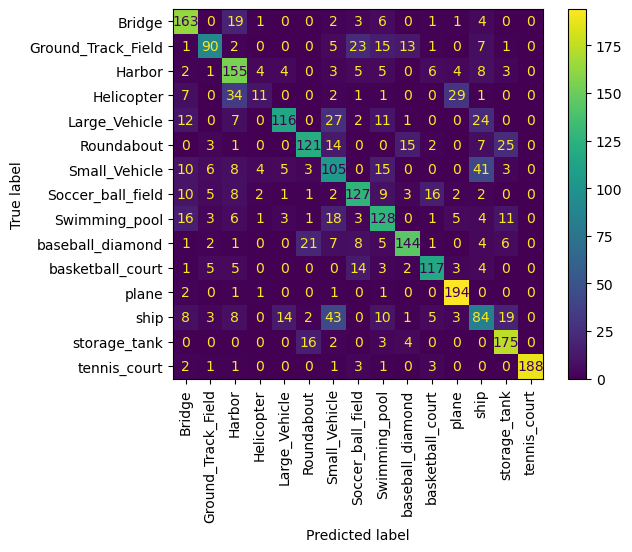

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=HOG_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=HOG_pipeline.classes_)
disp.plot(xticks_rotation='vertical')
plt.show()

SVC с полиномиальным ядром:

In [16]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8), 
        cells_per_block=(3, 3), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(kernel='poly'))
])

HOG_pipeline.fit(X_train, y_train)
y_pred = HOG_pipeline.predict(X_test)
accuracy_score(y_test,y_pred)

0.5746214852198991

In [17]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

            Bridge       0.84      0.66      0.74       200
Ground_Track_Field       0.80      0.25      0.38       158
            Harbor       0.62      0.56      0.59       200
        Helicopter       0.91      0.12      0.21        86
     Large_Vehicle       0.98      0.47      0.64       200
        Roundabout       0.79      0.35      0.49       188
     Small_Vehicle       0.51      0.27      0.35       200
 Soccer_ball_field       0.60      0.45      0.52       188
     Swimming_pool       0.19      0.93      0.31       200
  baseball_diamond       0.75      0.69      0.72       200
  basketball_court       0.95      0.55      0.69       154
             plane       0.95      0.85      0.90       200
              ship       0.58      0.44      0.50       200
      storage_tank       0.90      0.77      0.83       200
      tennis_court       1.00      0.93      0.96       200

          accuracy                    

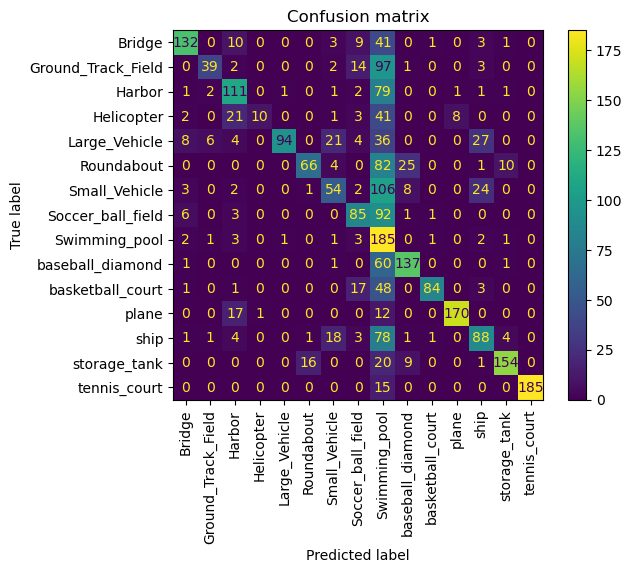

In [25]:
cm = confusion_matrix(y_test, y_pred, labels=HOG_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=HOG_pipeline.classes_)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix')
plt.show()

Лучше всего в качестве классификатора показали SVC с линейным и rbf ядрами. В целом алгоритм HOG+SVC неплохо справился с классификацией изображений. 